Esto es un test

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/visits_train.csv', parse_dates=['date_visit'], dayfirst=True)
df

,location,date_visit,visits
0,Madrid,2023-02-28,67.323720
1,Madrid,2023-02-27,71.894430
2,Madrid,2023-02-26,87.803810
3,Madrid,2023-02-25,90.435243
4,Madrid,2023-02-24,76.281122
...,...,...,...
1333,Barcelona,2021-05-05,43.053853
1334,Barcelona,2021-05-04,44.398808
1335,Barcelona,2021-05-03,47.631696
1336,Barcelona,2021-05-02,25.857399


<Figure size 1600x900 with 0 Axes>

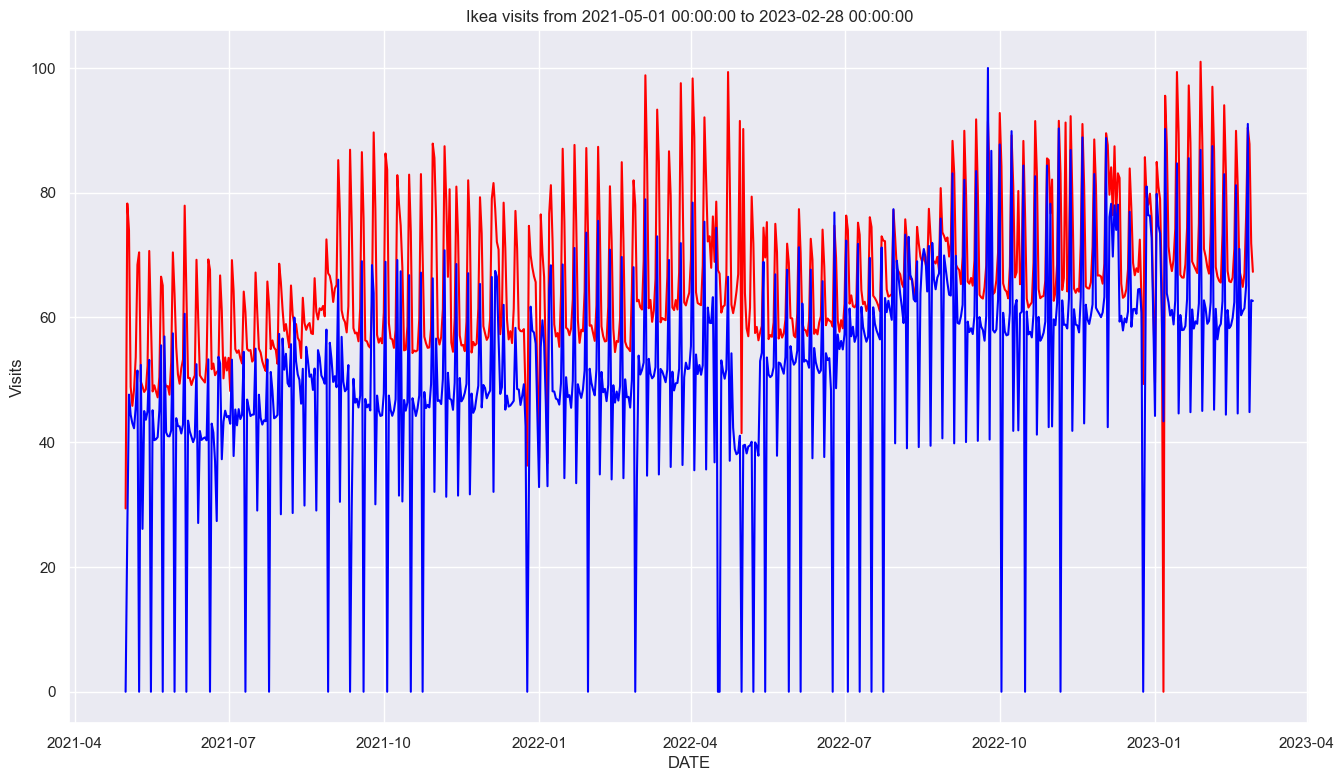

In [3]:
# Plotting a time series
sns.set(rc={'figure.figsize':(16,9)})
plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
dfMad = df[df.location == 'Madrid'].copy()
dfBcn = df[df.location == 'Barcelona'].copy()
ax.plot('date_visit','visits',data=dfMad, c = 'red')
ax.plot('date_visit','visits',data=dfBcn, c = 'blue')
ax.set(title=f'Ikea visits from {df.date_visit.min()} to {df.date_visit.max()}', xlabel='DATE', ylabel='Visits')
plt.show()

In [4]:
df[df.visits < 1]

,location,date_visit,visits
53,Madrid,2023-01-06,0.0
734,Barcelona,2022-12-25,0.0
783,Barcelona,2022-11-06,0.0
804,Barcelona,2022-10-16,0.0
818,Barcelona,2022-10-02,0.0
888,Barcelona,2022-07-24,0.0
895,Barcelona,2022-07-17,0.0
902,Barcelona,2022-07-10,0.0
909,Barcelona,2022-07-03,0.0
918,Barcelona,2022-06-24,0.0


In [5]:
import Billy.forecastingTools as FT

c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


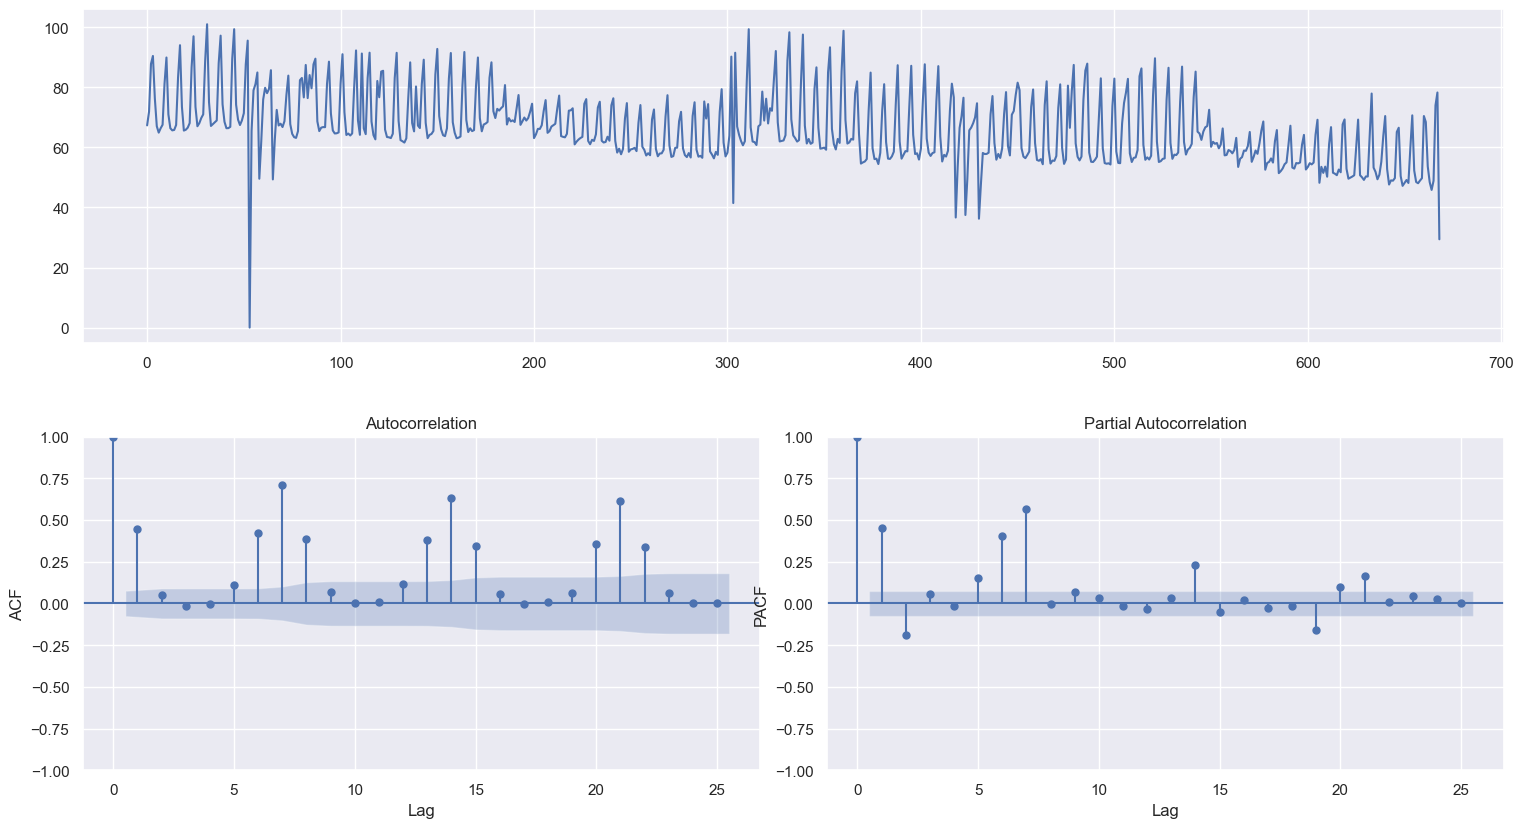

In [6]:
df_tsMad = dfMad['visits']
FT.ts_display(df_tsMad)

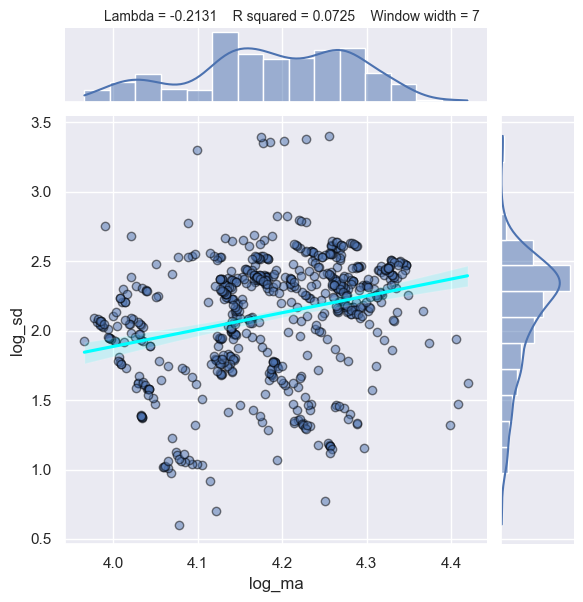

-0.21305507870424178

In [7]:
ww = 7
FT.boxcox_lambda_plot(df_tsMad, window_width=ww)

No se hace falta hacer la transformación box-cox

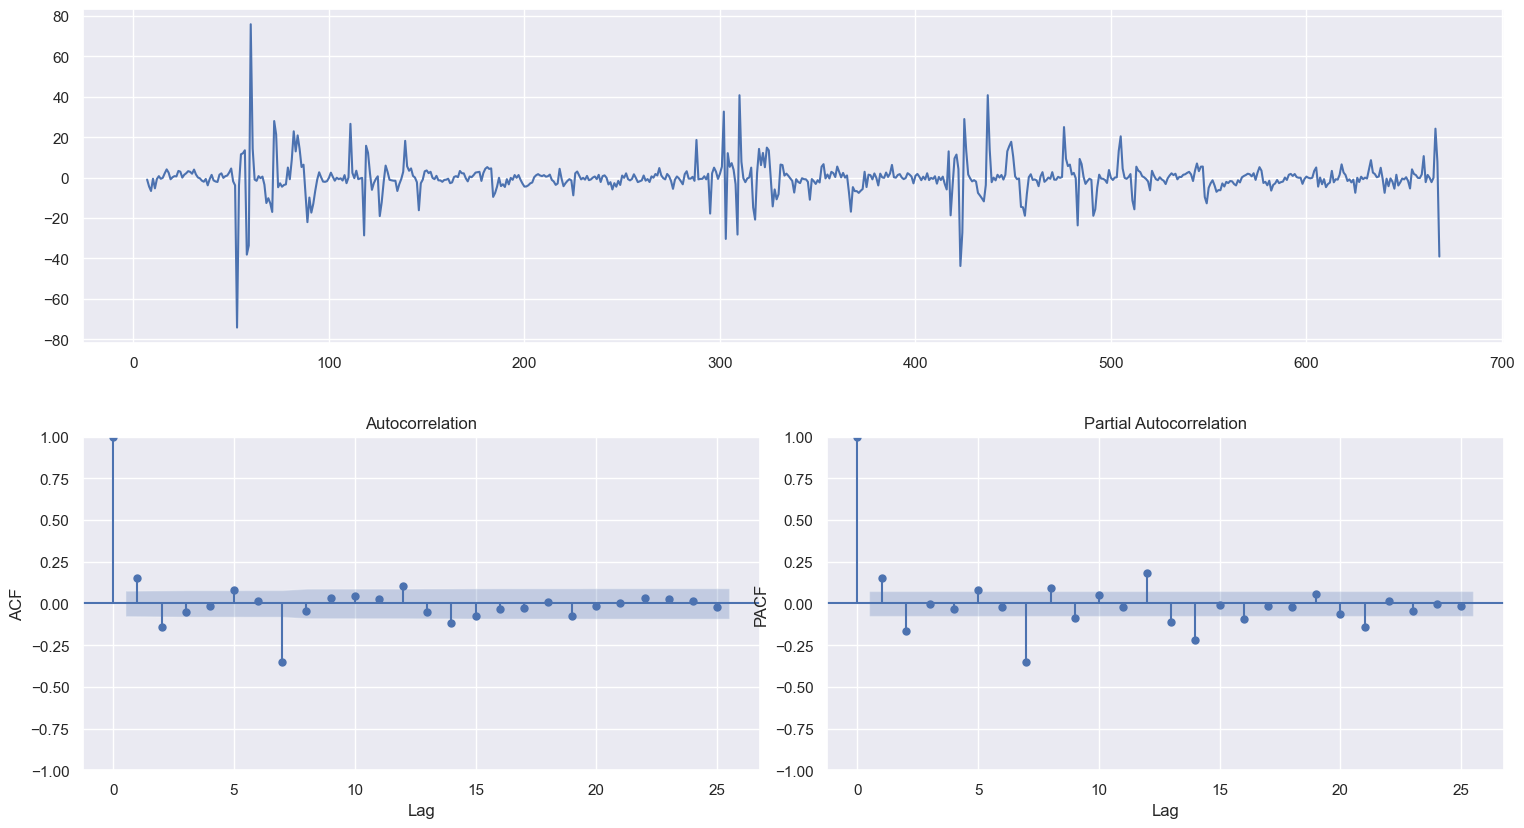

In [13]:
d = 0 #DIferenciación regular; y[t]-y[t-1]. Con eso se quita la 'tendencia gorda'
D =1 #Diferenciación estacional; y[t]-y[t-s]. Con esto se quita la 'tendencia estacional'
#Es en este momento, con d = 1 y D = 0, donde realmente se ve la tendencia estacional de los datos, al quitar la parte regular.
S = ww # Seasonality of ww days

Bz = df_tsMad.copy()
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz)


                                     SARIMAX Results                                     
Dep. Variable:                            visits   No. Observations:                  669
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -2210.012
Date:                           Sat, 15 Apr 2023   AIC                           4432.024
Time:                                   13:01:27   BIC                           4458.914
Sample:                                        0   HQIC                          4442.452
                                           - 669                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0345      0.081     -0.426      0.670      -0.193       0.124
drift         -0.0003      0.000     -1.310

c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  54.596288   0.000556


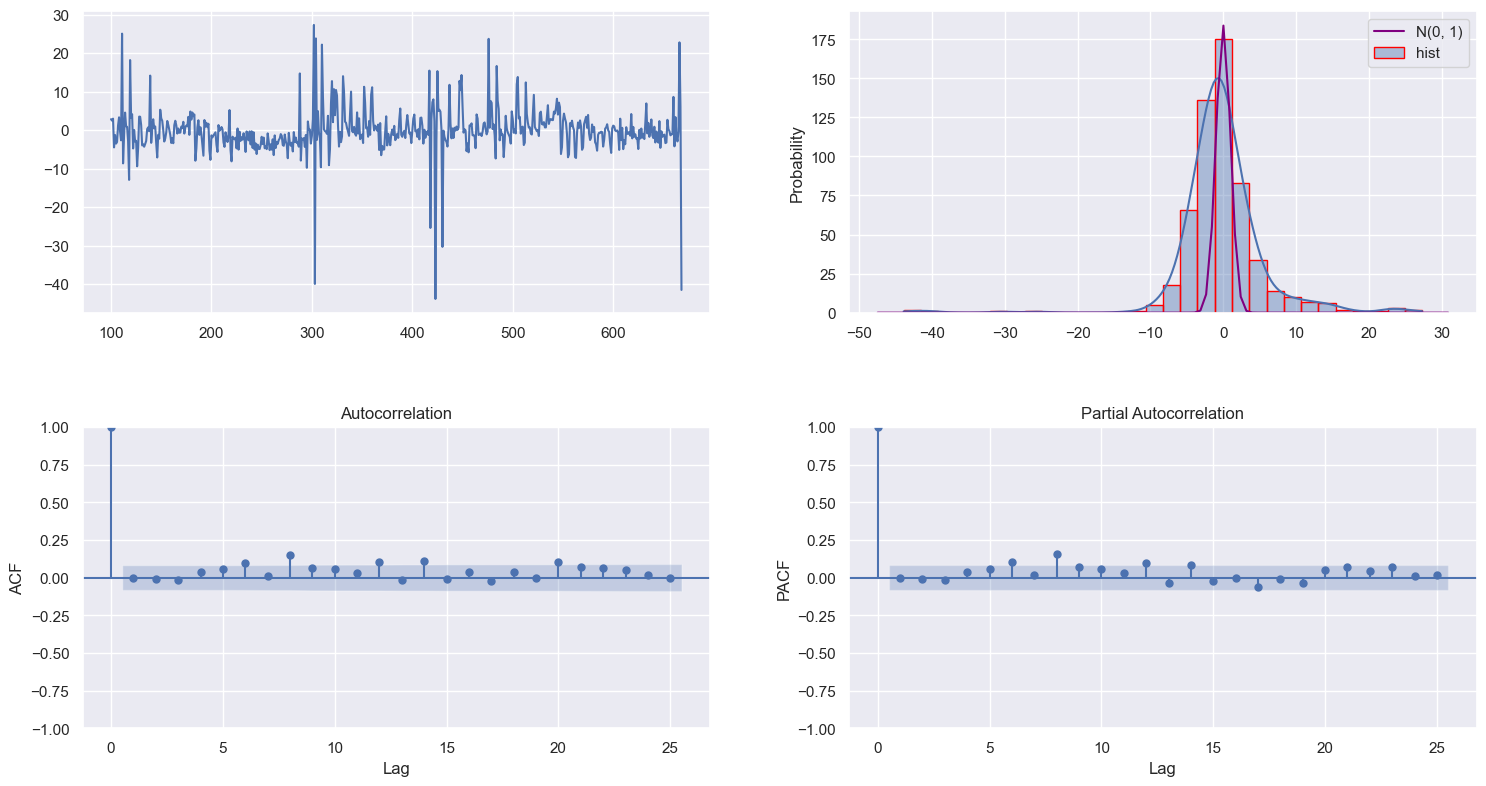

In [17]:

#Se han cambiado el valor del parámetro de diferenciación para que se haga de manera automática, usando el valor seleccionado en la celda anterior.
sarima_fit = SARIMAX(df_tsMad, 
                    order=(0,d,1), # Regular components. Para hallar estos valores nos fijamos únicamente en los primeros
                    seasonal_order=(1, D,1 , ww), # Seasonal components
                    trend= 'ct', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

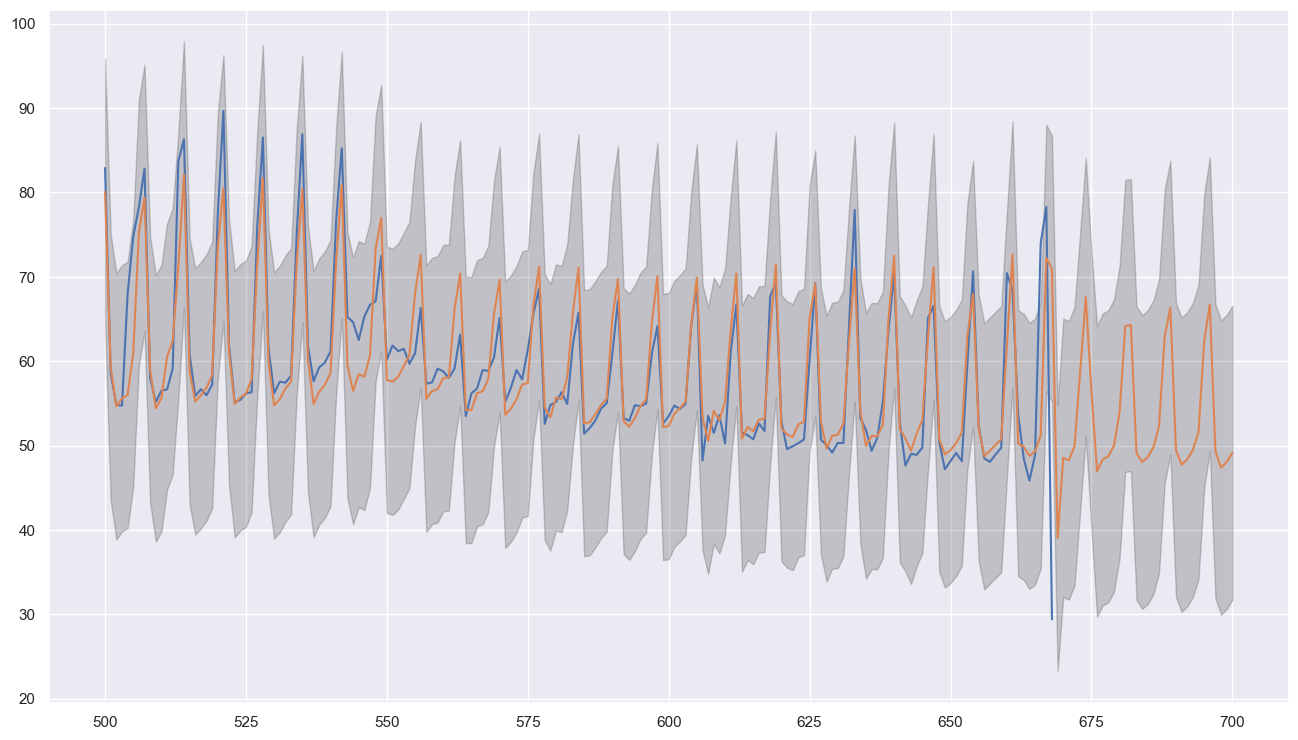

In [18]:
#Obtain forecasts for in-sample and out-of-sample
start = 500
horizon = 31
end = df_tsMad.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_tsMad.loc[start:])
plt.plot(yhat)
plt.show()